In [10]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from src.model import CRNN
import os

In [3]:
!where python3

/bin/bash: where: command not found


## load model

In [11]:
# config路徑: cc-ws-ocr/07.retrain/crnn_ctc/crnn-pytorch/src/config_mlflow.py
from src.config_mlflow import evaluate_config as config

In [12]:
# model = CRNN(img_channel=32, img_height=128, img_width=128, num_class=5)
num_class = 42
model = CRNN(1, config['img_height'], config['img_width'], num_class,
                map_to_seq_hidden=config['map_to_seq_hidden'],
                rnn_hidden=config['rnn_hidden'],
                leaky_relu=config['leaky_relu'])
path = '/home/jovyan/cc-ws-ocr/00.resources/mlflow/mlruns/0/7b6cf53aa92e468c863b2a807603f580/artifacts/best_checkpoint/state_dict.pth'
checkpoint = torch.load(path) #, map_location='cpu'
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [65]:
# model = CRNN(img_channel=32, img_height=128, img_width=128, num_class=5)

In [7]:
model.cnn

Sequential(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inpla

## Graph 1: Absolute sum of filter weights for each layer

In [37]:
import matplotlib.pyplot as plt

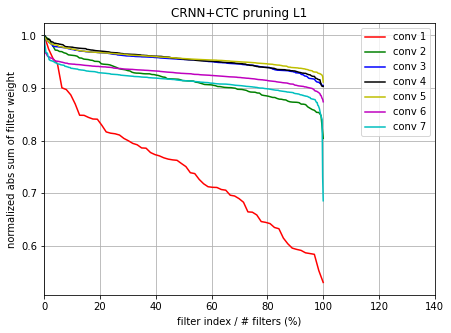

In [78]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

plt.figure(figsize=(7,5))
conv_count = 0
for layer in model.cnn: # 放入自己的 model
    if isinstance(layer, nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # 取出各層的 filter 
        fw = layer.weight.data.cpu().numpy()
        
        # 取絕對值 + 排序 (大到小)
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # 將權重標準化 0~1 之間
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("CRNN+CTC pruning L1")        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1_finetune.png", dpi=150, bbox_inches='tight')
plt.show()

## set param

In [13]:
# 原cfg
# cfg = [64, 128, 256, 256, 512, 512, 512]
cfg = []
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        out_channels = m.weight.data.shape[0]
        cfg.append(out_channels)
print(cfg) # total=2240

[64, 128, 256, 256, 512, 512, 512]


In [41]:
# 想剪的layer name
# pruning_rate_list = [0.6, 0.2, 0, 0, 0, 0.2, 0.2] #-> 0.12
# pruning_rate_list = [0.9, 0.7, 0.3, 0.3, 0.3, 0.7, 0.7] #-> 0.52
pruning_rate_list = [0.9, 0.9, 0.7, 0.6, 0.7, 0.9, 0.9] # -> 0.8

In [42]:
# make cfg new
cfg_new = [1]
for i, out_channels in enumerate(cfg):
    num_keep = int(out_channels * (1 - pruning_rate_list[i]))
    cfg_new.append(num_keep)
    print(f'Conv{i}, total channel:{out_channels}, remaining channel:{num_keep}')
cfg_new

Conv0, total channel:64, remaining channel:6
Conv1, total channel:128, remaining channel:12
Conv2, total channel:256, remaining channel:76
Conv3, total channel:256, remaining channel:102
Conv4, total channel:512, remaining channel:153
Conv5, total channel:512, remaining channel:51
Conv6, total channel:512, remaining channel:51


[1, 6, 12, 76, 102, 153, 51, 51]

In [43]:
# 總共剪的比例
print('total:', sum(cfg))
print('after pruning:', sum(cfg_new))
1 - sum(cfg_new) / sum(cfg)

total: 2240
after pruning: 452


0.7982142857142858

In [44]:
cfg_mask = []
# cfg_new = [1]
conv_id = 1
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        out_channels = m.weight.data.shape[0]

        weight_copy = m.weight.data.abs().clone()
        weight_copy = weight_copy.cpu().numpy()
#         num_keep = int(out_channels * (1 - pruning_rate)) # 要留下多少比例 (1 - pruning rate)
        # print('num_keep:', num_keep)
        L1_norm = np.sum(weight_copy, axis=(1, 2, 3)) # 算L1 全部加總
        arg_max = np.argsort(L1_norm)
        # x中的元素從小到大排列，提取其對應的index(索引)，然後輸出到y
        # x=np.array([1,4,3,-1,6,9])
        # y=array([3,0,2,1,4,5])

        # arg_max_rev = arg_max[::-1][:cfg[layer_id]]
        #[::-1]小排到大，[:num_keep]取要留下的
        arg_max_rev = arg_max[::-1][:cfg_new[conv_id]] # 留下哪幾個filters
        # print('arg_max_rev:', len(arg_max_rev))
        # print(arg_max_rev)

        # assert arg_max_rev.size == cfg[layer_id], "size of arg_max_rev not correct"
        mask = torch.zeros(out_channels) # 一個空的 裡面都存0的matrix， 1*out_channels維
        mask[arg_max_rev.tolist()] = 1 # 把要留下的人給1
        cfg_mask.append(mask) # [tensor(一堆0, 1), tensor(一堆0, 1)]
#         cfg_new.append(num_keep)
        
        print(f'Conv{conv_id-1}, total channel:{out_channels}, remaining channel:{cfg_new[conv_id]}')
        conv_id+=1

Conv0, total channel:64, remaining channel:6
Conv1, total channel:128, remaining channel:12
Conv2, total channel:256, remaining channel:76
Conv3, total channel:256, remaining channel:102
Conv4, total channel:512, remaining channel:153
Conv5, total channel:512, remaining channel:51
Conv6, total channel:512, remaining channel:51


In [79]:
# check cfg_mask
cfg_mask

[tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.

## save weights to new model

In [9]:
# cfg
'''
model: 各架構位置
skip: 不剪枝的層數
cfg: 剪枝後剩餘的 channel 數量
cfg_mask: 剪枝後剩餘 channel 的位置
cat_layer: 有 concat 的層數
'''
pruning_cfg = {
    'cnn':{
        'model': model.cnn,
        'skip': [],
        'cfg': cfg_new,
        'cfg_mask': cfg_mask,
        'cat_layer': []
    }
}
print(pruning_cfg['cnn']['cfg'])

[1, 32, 128, 256, 256, 512, 512, 512]


In [ ]:
# 用新的 cfg 定義新模型架構
# newmodel = CRNN(img_channel=1, img_height=32, img_width=100, num_class=42, pruning_cfg=pruning_cfg['cnn']['cfg'])

In [45]:
# 用新的 cfg 定義新模型架構
newmodel = CRNN(1, config['img_height'], config['img_width'], num_class,
                map_to_seq_hidden=config['map_to_seq_hidden'],
                rnn_hidden=config['rnn_hidden'],
                leaky_relu=config['leaky_relu'],
                pruning_cfg=cfg_new)

In [11]:
newmodel

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [46]:
start_mask = torch.ones(1)
layer_id_in_cfg = 0
end_mask = cfg_mask[layer_id_in_cfg]
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.BatchNorm2d):
        print('batch', layer_id_in_cfg)
        print('======================')
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        if idx1.size == 1:
            idx1 = np.resize(idx1,(1,))
        m1.weight.data = m0.weight.data[idx1.tolist()].clone()
        m1.bias.data = m0.bias.data[idx1.tolist()].clone()
        m1.running_mean = m0.running_mean[idx1.tolist()].clone()
        m1.running_var = m0.running_var[idx1.tolist()].clone()
        layer_id_in_cfg += 1
        start_mask = end_mask
        if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
            end_mask = cfg_mask[layer_id_in_cfg]
    elif isinstance(m0, nn.Conv2d):
        print('conv', layer_id_in_cfg)
        idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
        idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
        print('In shape: {:d}, Out shape {:d}.'.format(idx0.size, idx1.size))
        if idx0.size == 1:
            idx0 = np.resize(idx0, (1,))
        if idx1.size == 1:
            idx1 = np.resize(idx1, (1,))
        w1 = m0.weight.data[:, idx0.tolist(), :, :].clone()
        w1 = w1[idx1.tolist(), :, :, :].clone()
        m1.weight.data = w1.clone()
        # print(m1.weight.data.shape)
        # break
    elif isinstance(m0, nn.Linear):
        if layer_id_in_cfg == len(cfg_mask):
            print('Linear:', layer_id_in_cfg)
            idx0 = np.squeeze(np.argwhere(np.asarray(cfg_mask[-1].cpu().numpy())))
            if idx0.size == 1:
                idx0 = np.resize(idx0, (1,))
            m1.weight.data = m0.weight.data[:, idx0].clone()
            m1.bias.data = m0.bias.data.clone()
            layer_id_in_cfg += 1
            continue
        m1.weight.data = m0.weight.data.clone()
        m1.bias.data = m0.bias.data.clone()

conv 0
In shape: 1, Out shape 6.
batch 0
conv 1
In shape: 6, Out shape 12.
batch 1
conv 2
In shape: 12, Out shape 76.
batch 2
conv 3
In shape: 76, Out shape 102.
batch 3
conv 4
In shape: 102, Out shape 153.
batch 4
conv 5
In shape: 153, Out shape 51.
batch 5
conv 6
In shape: 51, Out shape 51.
batch 6
Linear: 7


In [47]:
# save newmodel
torch.save({'state_dict': newmodel.state_dict(), 'acc': 0, 'pruning_cfg': cfg_new}, os.path.join('./pruning_checkpoints/newmodel_pruning_l1_80.pth'))

In [ ]:
# load model
from src.config import evaluate_config as config
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
num_class=42
reload_checkpoint = '/home/jovyan/cc-ws-ocr/00.resources/mlflow/mlruns/3/f4d51d4b9d7a47088f0eb217c9442346/artifacts/best_checkpoint/state_dict.pth'
device = 'cuda'
pruning_cfg = [1, 6, 38, 179, 179, 358, 153, 153]
checkpoint = torch.load(reload_checkpoint, map_location=device)
crnn = CRNN(1, config['img_height'], config['img_width'], num_class,
                map_to_seq_hidden=config['map_to_seq_hidden'],
                rnn_hidden=config['rnn_hidden'],
                leaky_relu=config['leaky_relu'],
                pruning_cfg=pruning_cfg) #
crnn.load_state_dict(checkpoint['state_dict'])


In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# reload_checkpoint = '/home/jovyan/cc-ws-ocr/00.resources/mlflow/mlruns/3/f4d51d4b9d7a47088f0eb217c9442346/artifacts/best_checkpoint/state_dict.pth'
# device = 'cuda'
# pruning_cfg = [1, 6, 38, 179, 179, 358, 153, 153]
# checkpoint = torch.load(reload_checkpoint, map_location=device)
# torch.save({'state_dict': checkpoint['state_dict'], 'acc': 0, 'pruning_cfg': pruning_cfg}, reload_checkpoint)

In [32]:
# 新的 model
# torch.size() 順序是 output channel,  input channel, kernel size
for i in newmodel.cnn.state_dict():
    if ('conv' in i) and ('weight' in i):
        print(("================= {} =================").format(i.split('.')[0]))
        print('Conv shape: {}'.format(newmodel.cnn.state_dict()[i].shape))
    if ('batchnorm' in i) and ('weight' in i):
        print('Batch shape: {}'.format(newmodel.cnn.state_dict()[i].shape))

================= conv0 =================
Conv shape: torch.Size([32, 1, 3, 3])
Batch shape: torch.Size([32])
================= conv1 =================
Conv shape: torch.Size([128, 32, 3, 3])
Batch shape: torch.Size([128])
================= conv2 =================
Conv shape: torch.Size([256, 128, 3, 3])
Batch shape: torch.Size([256])
================= conv3 =================
Conv shape: torch.Size([230, 256, 3, 3])
Batch shape: torch.Size([230])
================= conv4 =================
Conv shape: torch.Size([512, 230, 3, 3])
Batch shape: torch.Size([512])
================= conv5 =================
Conv shape: torch.Size([512, 512, 3, 3])
Batch shape: torch.Size([512])
================= conv6 =================
Conv shape: torch.Size([512, 512, 2, 2])
Batch shape: torch.Size([512])


## compare

In [16]:
for [m0, m1] in zip(model.modules(), newmodel.modules()):
    if isinstance(m0, nn.Conv2d):
        old = m0.weight.data
        new = m1.weight.data
        break

In [17]:
old.shape

torch.Size([64, 1, 3, 3])

In [19]:
new.shape

torch.Size([32, 1, 3, 3])

In [15]:
cfg_mask[0]

tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 1.])

In [33]:
old[10]

tensor([[[ 0.2519, -0.3825,  0.2713],
         [-0.2458, -0.1120,  0.2800],
         [ 0.1923, -0.3685,  0.0497]]])

In [35]:
new[3]

tensor([[[ 0.2519, -0.3825,  0.2713],
         [-0.2458, -0.1120,  0.2800],
         [ 0.1923, -0.3685,  0.0497]]])